In [1]:
import yt 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os

In [ ]:
def load_data(data_dir, fields):
    ds = yt.load(data_dir)

    max_level = ds.index.max_level
    ref = int(np.prod(ds.ref_factors[0:ds.index.max_level]))
    low = ds.domain_left_edge
    dims = ds.domain_dimensions*ref

    cube = ds.covering_grid(max_level, left_edge=low, dims=dims, fields=fields)

    return ds, cube


def make_ke_ps(data_dir):
    ke_vec = ["RHOB", "WVX", "WVY", "WVZ"]
    ds, cube = load_data(data_dir, ke_vec)

    rho = cube["RHOB"].d
    gvx = cube["WVX"].d
    gvy = cube["WVY"].d
    gvz = cube["WVZ"].d

    nx, ny, nz = rho.shape

    lorentz = np.zeros_like(rho)
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                lorentz[i, j, k] = np.sqrt(1 + gvx[i, j, k] ** 2 + gvx[i, j, k] ** 2 + gvz[i, j, k] ** 2)

    vx = gvx/lorentz
    vy = gvy/lorentz
    vz = gvz/lorentz

    nindex_rho = 1/3

    Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))

    for vel in [vx, vy, vz]:
        ru = np.fft.fftn(rho**nindex_rho * vel)[0:nx//2+1, 0:ny//2+1, 0:nz//2+1]
        ru = 8 * ru/(nx*ny*nz)
        Kk += 0.5 * np.abs(ru)**2

    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx) * nx / L[0]
    ky = np.fft.rfftfreq(ny) * ny / L[1]
    kz = np.fft.rfftfreq(nz) * nz / L[2]

    kmin = np.min(1/L)
    #kmax = np.min(0.5 * dims/L)
    kmax = 128 ### REMEMBER TO CHANGE THIS WHEN GOING TO 3D

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2, kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount) - 1)

    for n in range(1, len(ncount)):
        E_spectrum[n-1] = np.sum(Kk.flat[whichbin == n])

    k = 0.5 * (kbins[0:N-1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N]

    index = np.argmax(E_spectrum)
    kmax = k[index]
    Emax = E_spectrum[index]

    return k, E_spectrum, index, kmax, Emax

def pull_data_into_ke_ps(data_dir):
    data_subdir = [name for name in os.listdir(data_dir)]
    data_subdir.sort(key=str.lower)

    snapshots = len(data_subdir)

    data = np.zeros((2, 254, snapshots))

    for i in range(snapshots):
        path = data_dir + data_subdir[i]
        data[:,:, i] = make_ke_ps(path)

    return data, data_subdir



In [ ]:
data_dir = r'0.1_1e6/'

fields_test = ["RHOB", "EPS", "WVX", "WVY", "WVZ"]
ds, cube = load_data(data_dir, fields_test)

In [3]:
ds = yt.load(data_dir)

yt : [INFO     ] 2024-06-27 10:53:41,337 Parameters: current_time              = 20.0
yt : [INFO     ] 2024-06-27 10:53:41,337 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2024-06-27 10:53:41,338 Parameters: domain_left_edge          = [-1. -1.  0.]
yt : [INFO     ] 2024-06-27 10:53:41,338 Parameters: domain_right_edge         = [1. 1. 1.]


In [5]:
ref = int(np.prod(ds.ref_factors[0:ds.index.max_level]))
low = ds.domain_left_edge
dims = ds.domain_dimensions*ref
print(dims)

[512 512   1]


In [18]:
print(ds.domain_dimensions[0])

512


In [6]:
cube = ds.covering_grid(max_level, left_edge=low, dims=dims, fields=fields_test)

In [7]:
rho = cube["RHOB"].d
eps = cube["EPS"].d
gvx = cube["WVX"].d
gvy = cube["WVY"].d
gvz = cube["WVZ"].d
temp = eps/rho

In [16]:
print(gvx.shape)

(512, 512, 1)


In [8]:
nx, ny, nz = rho.shape

In [9]:
lorentz = np.zeros_like(gvx)
for i in range(nx):
    for j in range(ny): 
        for k in range(nz):
            lorentz[i, j, k] = np.sqrt(1 + gvx[i, j, k]**2 + gvx[i, j, k]**2 + gvz[i, j, k]**2)

In [10]:
vx = gvx/lorentz 
vy = gvy/lorentz 
vz = gvz/lorentz

In [11]:
nindex_rho = 1/3

In [12]:
Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))

for vel in [vx, vy, vz]: 
    ru = np.fft.fftn(rho**nindex_rho * vel)[0:nx//2+1, 0:ny//2+1, 0:nz//2+1] 
    ru = 8 * ru/(nx*ny*nz)
    Kk += 0.5 * np.abs(ru)**2

In [13]:
L = (ds.domain_right_edge - ds.domain_left_edge).d 

kx = np.fft.rfftfreq(nx) * nx / L[0]
ky = np.fft.rfftfreq(ny) * ny / L[1]
kz = np.fft.rfftfreq(nz) * nz / L[2]

kmin = np.min(1/L) 
#kmax = np.min(0.5 * dims/L)
kmax = 128

kbins = np.arange(kmin, kmax, kmin) 
N = len(kbins)

kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
k = np.sqrt(kx3d**2 + ky3d**2, kz3d**2)

whichbin = np.digitize(k.flat, kbins)
ncount = np.bincount(whichbin)

E_spectrum = np.zeros(len(ncount) - 1) 

for n in range(1, len(ncount)): 
    E_spectrum[n-1] = np.sum(Kk.flat[whichbin == n])

k = 0.5 * (kbins[0:N-1] + kbins[1:N])
E_spectrum = E_spectrum[1:N]

index = np.argmax(E_spectrum)
kmax = k[index]
Emax = E_spectrum[index]

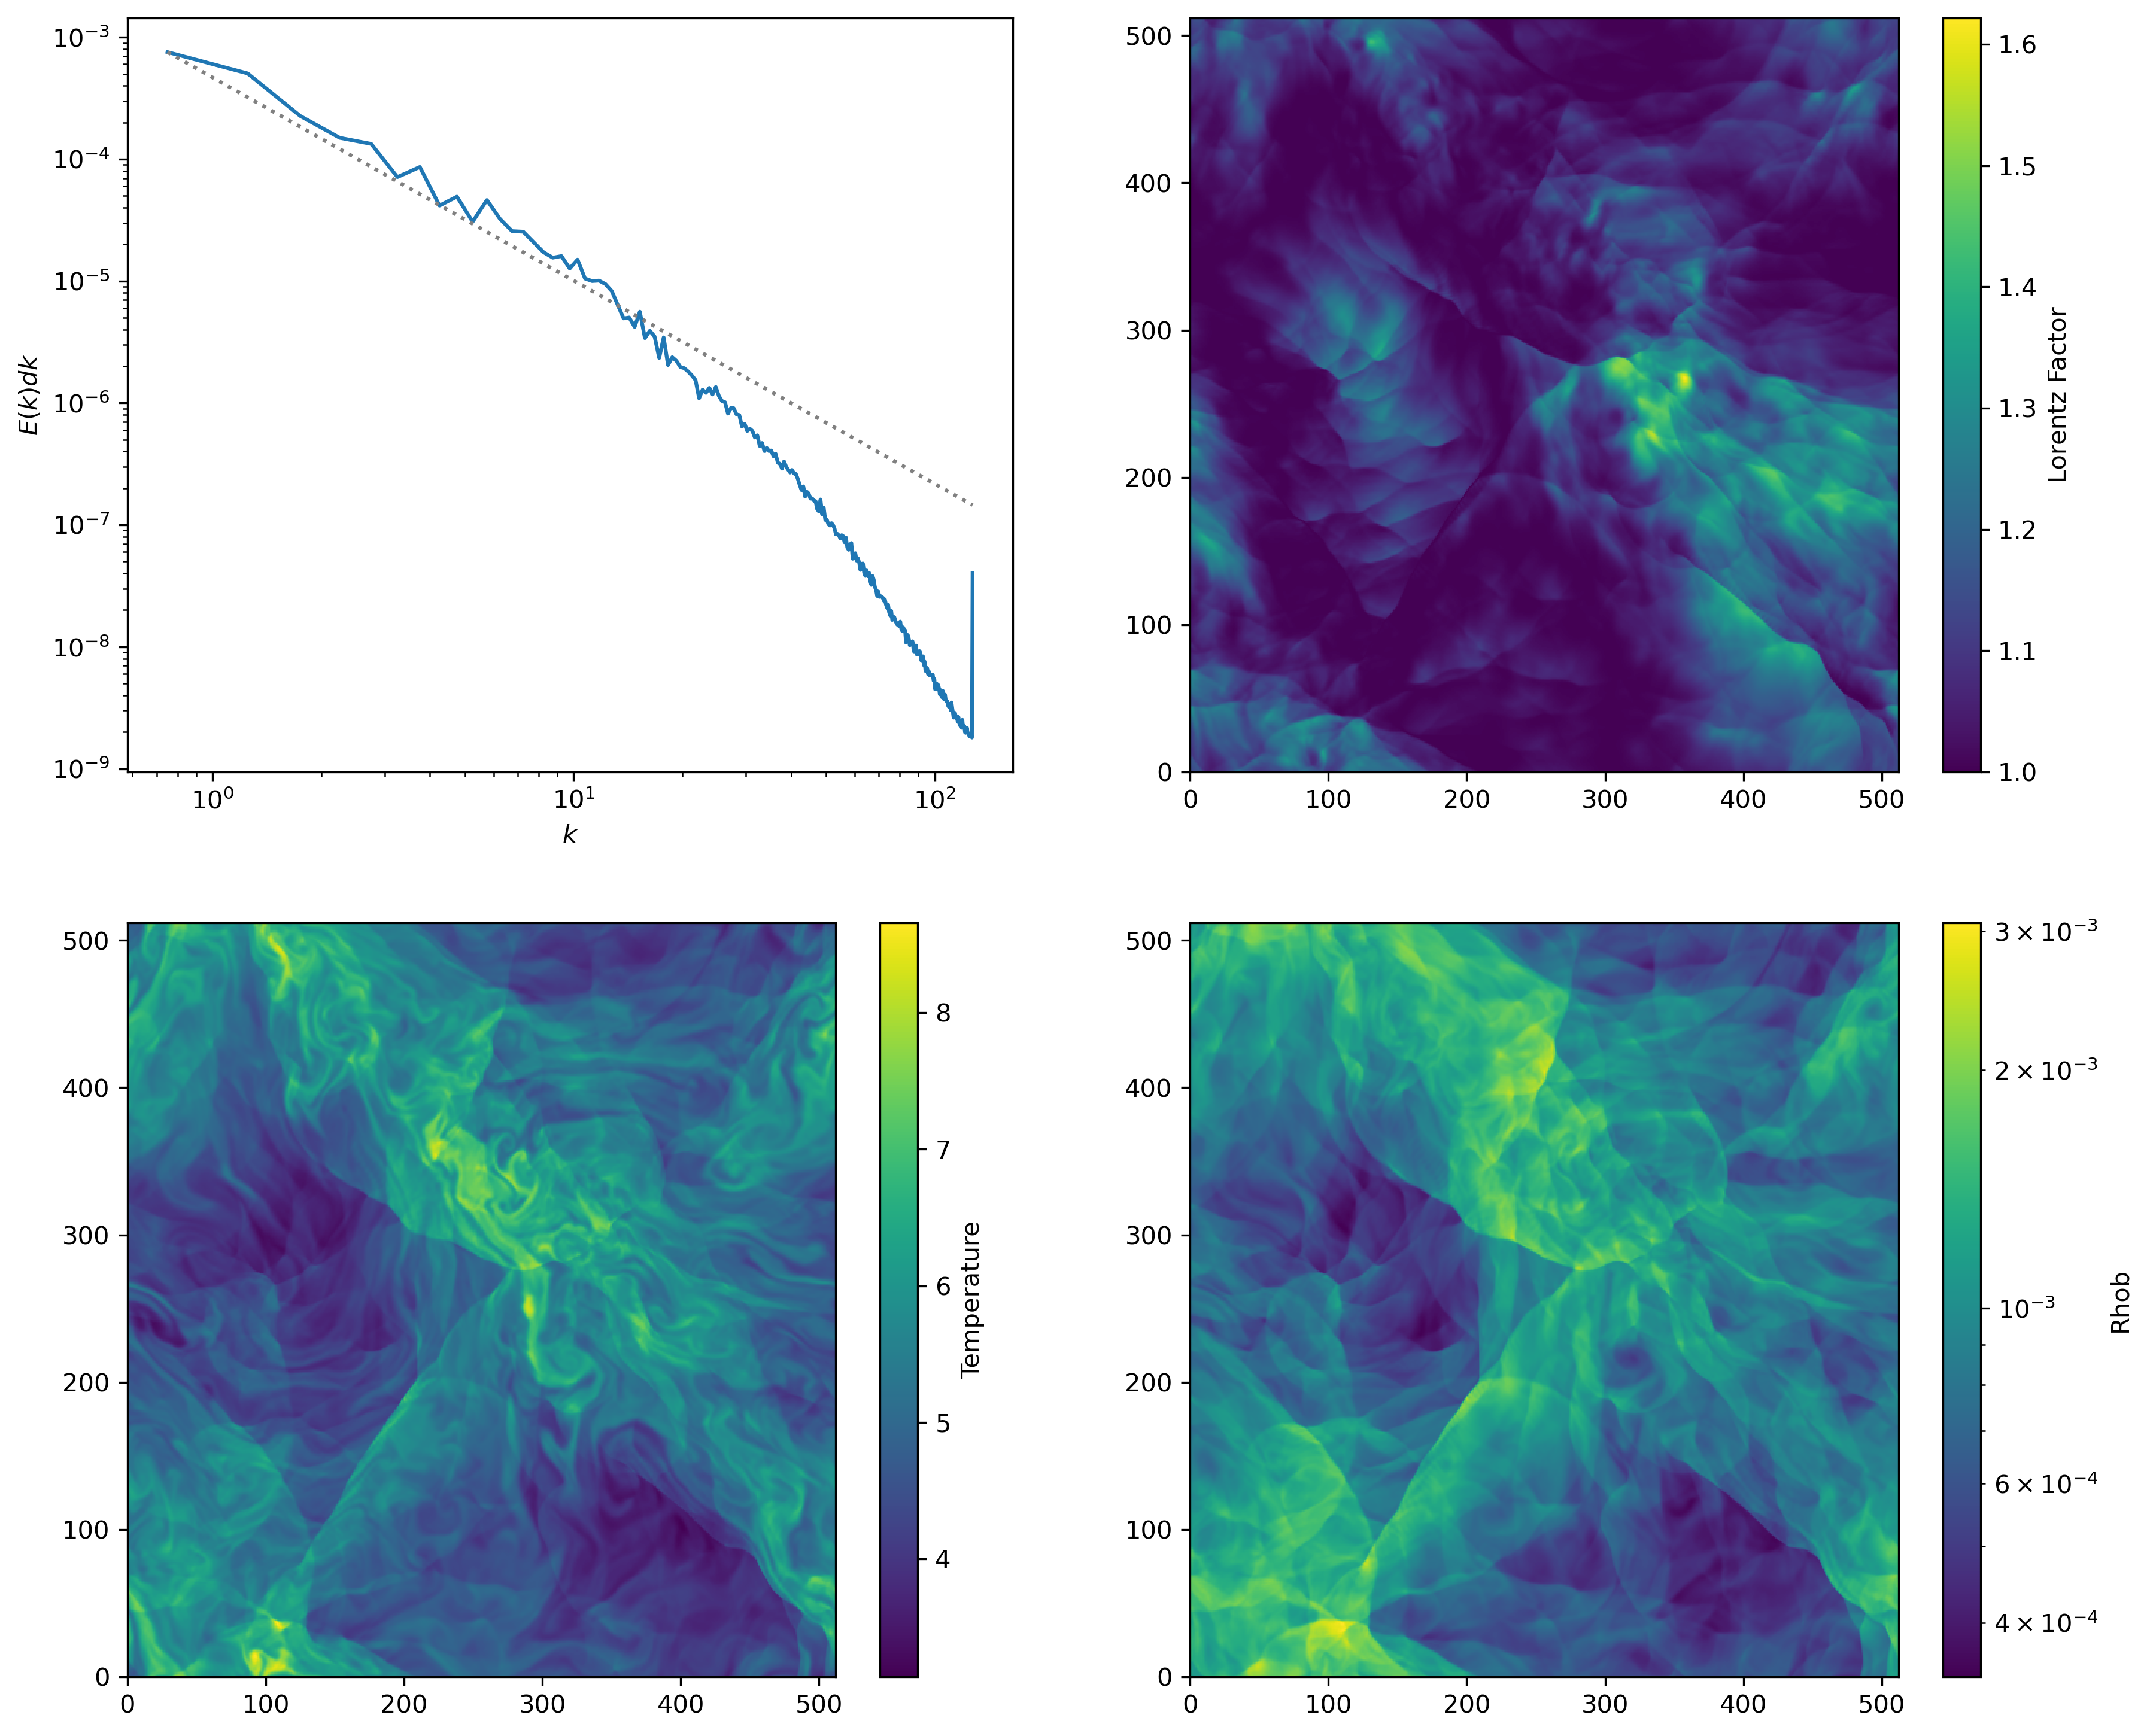

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(14,12), dpi=300) 

ax[0, 0].loglog(k, E_spectrum)
ax[0, 0].loglog(k, Emax*(k/kmax)**(-5/3), ls=':', color="0.5")
ax[0, 0].set_xlabel(r"$k$") 
ax[0, 0].set_ylabel(r"$E(k)dk$")

im1 = ax[0, 1].pcolormesh(lorentz[:,:,0])
fig.colorbar(im1, ax=ax[0,1], label=r'Lorentz Factor')

im2 = ax[1, 0].pcolormesh(temp[:,:,0])
fig.colorbar(im2, ax=ax[1,0], label=r'Temperature')

im3 = ax[1, 1].pcolormesh(rho[:, :, 0], norm=colors.LogNorm())
fig.colorbar(im3, ax=ax[1,1], label=r'Rhob')

#plt.show()
plt.savefig('plt20480_tcorr=0.4_dedt=1e6.png', dpi=300)